# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 23 in lake_model.py to identify the name to use for each lever.




In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [2]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

policy = Policy("no release", **{l.name:0 for l in lake_model.levers})
n_scenarios = 1000
results = perform_experiments(lake_model, n_scenarios, policy)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


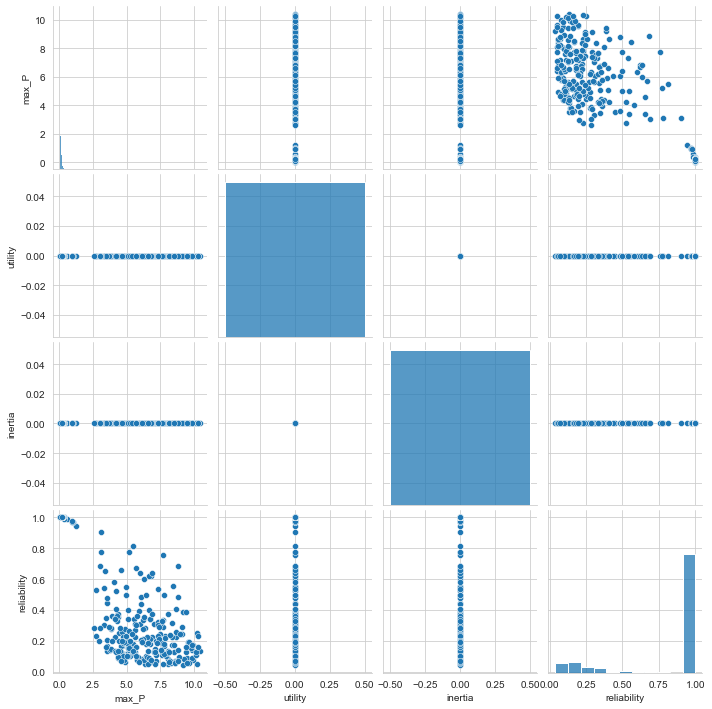

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

experiments, outcomes = results

sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

[MainProcess/INFO] no time dimension found in results


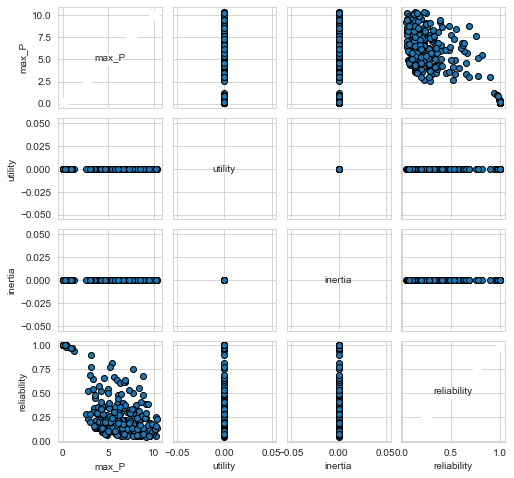

In [4]:
from ema_workbench.analysis import pairs_plotting

pairs_plotting.pairs_scatter(experiments, outcomes)

fig = plt.gcf()
fig.set_size_inches(8,8)

plt.show()

In [5]:
experiments.head()

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.144581,0.977533,0.020512,4.195136,0.002843,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,no release,lakeproblem
1,0.230335,0.956052,0.042365,2.620354,0.001229,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,no release,lakeproblem
2,0.251518,0.977328,0.015177,3.006608,0.004852,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,no release,lakeproblem
3,0.113840,0.980391,0.026384,4.287277,0.004454,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,no release,lakeproblem
4,0.253181,0.937903,0.015480,4.391031,0.001015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,no release,lakeproblem


In [14]:
cleaned = experiments.loc[:, [u.name for u in lake_model.uncertainties]]
cleaned.head()

,mean,stdev,b,q,delta
0,0.020512,0.002843,0.144581,4.195136,0.977533
1,0.042365,0.001229,0.230335,2.620354,0.956052
2,0.015177,0.004852,0.251518,3.006608,0.977328
3,0.026384,0.004454,0.113840,4.287277,0.980391
4,0.015480,0.001015,0.253181,4.391031,0.937903


In [16]:
cleaned['max_P'] = outcomes['max_P']

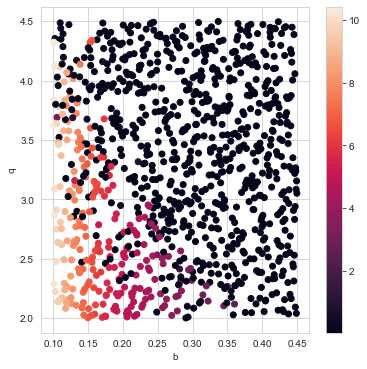

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

m = ax.scatter(cleaned.b, cleaned.q, c=cleaned.max_P)
ax.set_xlabel('b')
ax.set_ylabel('q')
fig.colorbar(m)

plt.show()

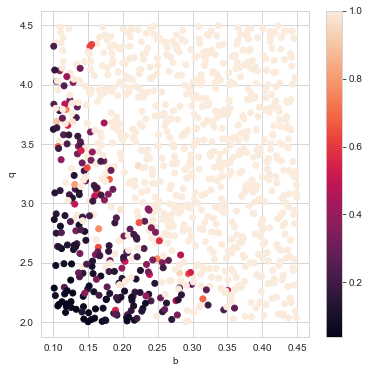

In [28]:
fig, ax = plt.subplots(figsize=(6,6))

m = ax.scatter(cleaned.b, cleaned.q, c=outcomes['reliability'])
ax.set_xlabel('b')
ax.set_ylabel('q')
fig.colorbar(m)

plt.show()

In [31]:
cleaned['reliability'] = outcomes['reliability']
cleaned.corr()

,mean,stdev,b,q,delta,max_P,reliability
mean,1.000000,-0.023160,0.023353,-0.074699,-0.012793,0.250034,-0.289633
stdev,-0.023160,1.000000,-0.009897,0.048499,0.003658,-0.012409,0.008860
b,0.023353,-0.009897,1.000000,0.037267,-0.015851,-0.616653,0.552902
q,-0.074699,0.048499,0.037267,1.000000,0.003320,-0.334959,0.447735
delta,-0.012793,0.003658,-0.015851,0.003320,1.000000,0.027456,-0.026092
max_P,0.250034,-0.012409,-0.616653,-0.334959,0.027456,1.000000,-0.934016
reliability,-0.289633,0.008860,0.552902,0.447735,-0.026092,-0.934016,1.000000


3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

In [5]:
n_scenarios = 1000
n_policies = 4
results = perform_experiments(lake_model, n_scenarios, n_policies)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


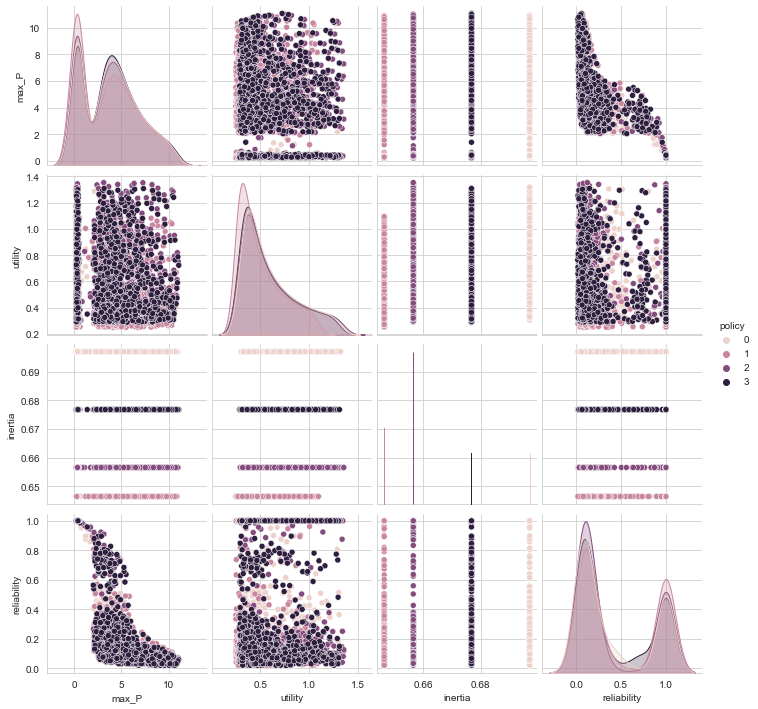

In [6]:
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each?
    * for windows users, carefully read [the python documentation](https://docs.python.org/3.6/library/multiprocessing.html). Can you use multiprocessing from within the notebook if the lake_model function is defined within the notebook?

In [7]:
from ema_workbench import MultiprocessingEvaluator

n_scenarios = 1000
n_policies = 4

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool



The ipyparallel Evaluator uses the ipyparallel library to suport multiprocessing. Working with this is a bit more involved than using multiprocessing. You first need to start ipcluster in cmd or a terminal:

    ipcluster start

next, you need a client to interact with this cluster.

In [9]:
import ipyparallel

client = ipyparallel.Client()
client.ids

[0, 1, 2, 3]


Next, we can define the lake model function. The %%px -local is known as a cell magic. This line means that the entire code block needs to be executed on all ipyarallel ipython engines, as well as in the ipython engine associated with the notebook.

In [14]:
%%px --local

import math
import numpy as np

from scipy.optimize import brentq

def lake_problem(b=0.42, q=2.0, mean=0.02, stdev=0.0017, delta=0.98,      
                 alpha=0.4, nsamples=100, steps=100, l0=0, l1=0, l2=0, l3=0,
                 l4=0, l5=0, l6=0, l7=0, l8=0, l9=0, l10=0, l11=0, l12=0, l13=0,
                 l14=0, l15=0, l16=0, l17=0, l18=0, l19=0, l20=0, l21=0, l22=0,
                 l23=0, l24=0, l25=0, l26=0, l27=0, l28=0, l29=0, l30=0, l31=0,
                 l32=0, l33=0, l34=0, l35=0, l36=0, l37=0, l38=0, l39=0, l40=0,
                 l41=0, l42=0, l43=0, l44=0, l45=0, l46=0, l47=0, l48=0, l49=0,
                 l50=0, l51=0, l52=0, l53=0, l54=0, l55=0, l56=0, l57=0, l58=0,
                 l59=0, l60=0, l61=0, l62=0, l63=0, l64=0, l65=0, l66=0, l67=0,
                 l68=0, l69=0, l70=0, l71=0, l72=0, l73=0, l74=0, l75=0, l76=0,
                 l77=0, l78=0, l79=0, l80=0, l81=0, l82=0, l83=0, l84=0, l85=0,
                 l86=0, l87=0, l88=0, l89=0, l90=0, l91=0, l92=0, l93=0, l94=0,
                 l95=0, l96=0, l97=0, l98=0, l99=0,):   
    decisions = np.array([l0, l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13,
                          l14, l15, l16, l17, l18, l19, l20, l21, l22, l23, l24, l25,
                          l26, l27, l28, l29, l30, l31, l32, l33, l34, l35, l36, l37,
                          l38, l39, l40, l41, l42, l43, l44, l45, l46, l47, l48, l49,
                          l50, l51, l52, l53, l54, l55, l56, l57, l58, l59, l60, l61,
                          l62, l63, l64, l65, l66, l67, l68, l69, l70, l71, l72, l73,
                          l74, l75, l76, l77, l78, l79, l80, l81, l82, l83, l84, l85,
                          l86, l87, l88, l89, l90, l91, l92, l93, l94, l95, l96, l97,
                          l98, l99])
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(decisions)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(decisions)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] +\
                    natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    inertia = np.sum(np.abs(np.diff(decisions)) > 0.02)/float(nvars-1)

    return max_P, utility, inertia, reliability



Now we can define our model as we did before. If you remove --local the code below will fail, can you explain why?

In [15]:
#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]


And now we are ready to execute our code, note that IpyparallelEvaluator requires the client as interface to the cluster.

In [16]:
from ema_workbench import  IpyparallelEvaluator

n_scenarios = 1000
n_policies = 4

with IpyparallelEvaluator(lake_model, client=client) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] performing experiments using ipyparallel
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
